# Covert Air Team Data from GeoTiff to CSV
Current Air Data is in 162 GeoTiffs. Would like to have 2 CSV files, 1 for 4km and 1 for 1km.

The goal is to make the spatial join with the Housing Unit level data faster.

Code also makes a vector version of the the grids. This will be joined with the point level data. After this join the CSV for the air data will be merged on the grid id.


## Description of Program
- program:    ip1_2av1_covertairtocsv
- task:       Convert geotiffs to csv files
- Version:    2025-12-19
- project:    Southeast Texas Urban Integrated Field Lab
- funding:	  DOE
- author:     Nathanael Rosenheim

## Step 0: Good Housekeeping

In [1]:
# 1. Import all packages
import pandas as pd     # For obtaining and cleaning tabular data
import geopandas as gpd # For obtaining and cleaning spatial data
import matplotlib.pyplot as plt # For plotting
import contextily as ctx # For adding basemaps
import os # For saving output to path
import zipfile # For handling zip files
import io # For handling in-memory data
import requests # For downloading data
import rasterio # For reading geotiff files

In [2]:
# 2. Check versions
import sys
print("Python Version     ", sys.version)
print("geopandas version: ", gpd.__version__)

Python Version      3.13.9 | packaged by conda-forge | (main, Oct 22 2025, 23:12:41) [MSC v.1944 64 bit (AMD64)]
geopandas version:  1.1.1


In [3]:
# 3. Check working directory
# Get information on current working directory (getcwd)
os.getcwd()

'c:\\Users\\nathanael99\\MyProjects\\GitHub\\integrate_people_theme1_cookbook'

In [16]:
#4. Store Program Name for output files to have the same name
programname = "ip1_2av1_covertairtocsv"
# Make directory to save output
if not os.path.exists(programname):
    os.mkdir(programname)

# Step 1: Obtain Data
Obtain publicly available data on CKAN

https://ckan.tacc.utexas.edu/organization/setx-uifl

### Simulated Percentile Concentrations of Hazardous Air Pollutants in Southeast Texas from the Comprehensive Air Quality Model with Extensions
https://ckan.tacc.utexas.edu/dataset/simulated-percentile-concentrations-of-hazardous-air-pollutants

Each file is named according to the following:

Authors: Elena McDonald-Buller; Yosuke Kimura

v720ut3_uifl_4km_1km_rtracv3_*_{gridname}_{species}_ppb_apr_oct_{statistics}.tif

- gridname is grd01 or grd02 specifying the modeling domain, uifl_4km or uifl_1km, respectively
- species can be antl (Acetonitrile), be13 (1,3-Butadiene), benz (Benzene), etbz (Ethylbenzene), etox (Ethylene Oxide), nhex (Hexane), strn (Styrene), tolu (Toluene) or xyln (mixed isomers of Xylenes).
- statistics has the format of pXX where XX is percentile, e.g. p50 represents the 50th percentile, or the word "mean" for mean.


In [5]:
# Add Air Pollution Data
air_pollution_url = "https://ckan.tacc.utexas.edu/dataset/c3c1b2b2-4d43-4603-b1c5-fc0877c279ae/resource/465209c8-f407-4eb2-99b3-4fc719e168c3/download/simulated_percentile_conc.zip"

# Dictionary to store the geotiff data organized by subfolders
air_pollution_dict = {}

# Mapping for species codes to full names
species_mapping = {
    'antl': 'Acetonitrile',
    'be13': '1,3-Butadiene',
    'benz': 'Benzene',
    'etbz': 'Ethylbenzene',
    'etox': 'Ethylene Oxide',
    'nhex': 'Hexane',
    'strn': 'Styrene',
    'tolu': 'Toluene',
    'xyln': 'Xylenes'
}

# Function to create descriptive key from filename
def create_descriptive_key(filename):
    """
    Parse filename structure and create descriptive key
    Filename structure: v720ut3_uifl_4km_1km_rtracv3_*_{gridname}_{species}_ppb_apr_oct_{statistics}.tif
        - gridname is grd01 or grd02 specifying the modeling domain, uifl_4km or uifl_1km, respectively
        - species can be antl (Acetonitrile), be13 (1,3-Butadiene), benz (Benzene), etbz (Ethylbenzene), etox (Ethylene Oxide), nhex (Hexane), strn (Styrene), tolu (Toluene) or xyln (mixed isomers of Xylenes).
        - statistics has the format of pXX where XX is percentile, e.g. p50 represents the 50th percentile, or the word "mean" for mean.
    example: 
        - Filename = v720ut3_uifl_4km_1km_rtracv3_bzhx_grd02_benz_ppb_apr_oct_p75
            - key = Benzene 75th percentile 1km
    """
    parts = filename.split('_')
    
    # Extract components from filename parts
    gridname = None
    species = None
    statistics = None
    
    for i, part in enumerate(parts):
        # Find gridname (grd01 or grd02)
        if part in ['grd01', 'grd02']:
            gridname = part
        # Find species code (should be after gridname)
        elif gridname and part in species_mapping:
            species = part
        # Find statistics (last meaningful part before extension)
        elif part.startswith('p') and part[1:].isdigit():
            statistics = part
        elif part == 'mean':
            statistics = part
    
    # Format statistics for key
    if statistics and statistics.startswith('p'):
        stat_display = f"p{statistics[1:]}"  # Keep percentile format shorter
    elif statistics == 'mean':
        stat_display = 'mean'
    else:
        stat_display = statistics if statistics else 'unknown'
    
    # Create descriptive key (shorter format)
    descriptive_key = stat_display
    
    return descriptive_key

# Download and read TIFF files from the zip
response = requests.get(air_pollution_url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    # Get list of all files in the zip
    file_list = z.namelist()
    
    # Filter for .tif files
    tif_files = [f for f in file_list if f.endswith('.tif') or f.endswith('.tiff')]
    
    print(f"Found {len(tif_files)} TIFF files in total")
    
    # Process each TIFF file and organize by subfolder structure
    for tif_file in tif_files:
        # Parse the file path
        path_parts = tif_file.split('/')
        
        if len(path_parts) >= 3:  # resolution/species/filename
            resolution_dir = path_parts[0]  # e.g., 'uifl_1km' or 'uifl_4km'
            species_dir = path_parts[1]     # e.g., 'benz', 'tolu', etc.
            filename = os.path.splitext(path_parts[2])[0]  # filename without extension
            
            # Create nested dictionary structure: resolution -> species -> statistic
            if resolution_dir not in air_pollution_dict:
                air_pollution_dict[resolution_dir] = {}
            
            # Get species full name
            species_name = species_mapping.get(species_dir, species_dir)
            
            if species_name not in air_pollution_dict[resolution_dir]:
                air_pollution_dict[resolution_dir][species_name] = {}
            
            # Create descriptive key for the statistic
            statistic_key = create_descriptive_key(filename)
            
            # Read the TIFF file data
            with z.open(tif_file) as file_data:
                # Use rasterio to read the geotiff
                with rasterio.open(file_data) as src:
                    # Store the rasterio dataset in the nested dictionary
                    air_pollution_dict[resolution_dir][species_name][statistic_key] = {
                        'data': src.read(),  # Read all bands
                        'transform': src.transform,
                        'crs': src.crs,
                        'meta': src.meta,
                        'bounds': src.bounds,
                        'width': src.width,
                        'height': src.height,
                        'original_filename': filename,  # Keep original filename for reference
                        'file_path': tif_file  # Keep original file path
                    }

print(f"\nSuccessfully organized {len(tif_files)} geotiff files into nested dictionary")
print(f"Resolution levels: {list(air_pollution_dict.keys())}")

# Display the structure
for resolution in air_pollution_dict.keys():
    species_count = len(air_pollution_dict[resolution])
    print(f"\n{resolution}: {species_count} species")
    for species in air_pollution_dict[resolution].keys():
        stat_count = len(air_pollution_dict[resolution][species])
        stats = list(air_pollution_dict[resolution][species].keys())
        print(f"  {species}: {stat_count} statistics ({', '.join(sorted(stats))})")

Found 162 TIFF files in total

Successfully organized 162 geotiff files into nested dictionary
Resolution levels: ['uifl_1km', 'uifl_4km']

uifl_1km: 9 species
  Benzene: 9 statistics (mean, p100, p25, p50, p75, p90, p95, p98, p99)
  Acetonitrile: 9 statistics (mean, p100, p25, p50, p75, p90, p95, p98, p99)
  1,3-Butadiene: 9 statistics (mean, p100, p25, p50, p75, p90, p95, p98, p99)
  Styrene: 9 statistics (mean, p100, p25, p50, p75, p90, p95, p98, p99)
  Ethylene Oxide: 9 statistics (mean, p100, p25, p50, p75, p90, p95, p98, p99)
  Toluene: 9 statistics (mean, p100, p25, p50, p75, p90, p95, p98, p99)
  Hexane: 9 statistics (mean, p100, p25, p50, p75, p90, p95, p98, p99)
  Ethylbenzene: 9 statistics (mean, p100, p25, p50, p75, p90, p95, p98, p99)
  Xylenes: 9 statistics (mean, p100, p25, p50, p75, p90, p95, p98, p99)

uifl_4km: 9 species
  Benzene: 9 statistics (mean, p100, p25, p50, p75, p90, p95, p98, p99)
  Acetonitrile: 9 statistics (mean, p100, p25, p50, p75, p90, p95, p98, p99)


# Step 3: Explore Data

In [6]:
# Texas cities coordinates for geographic context
texas_cities = {
    'Houston': {'lat': 29.7604, 'lon': -95.3698},
    'Beaumont': {'lat': 30.0860, 'lon': -94.1265}, 
    'Port Arthur': {'lat': 29.8849, 'lon': -93.9300},
    'Orange': {'lat': 30.0927, 'lon': -93.7565},
    'Bridge City': {'lat': 30.0254, 'lon': -93.8432},
    'Lufkin': {'lat': 31.3382, 'lon': -94.7291},
    'Tyler': {'lat': 32.3513, 'lon': -95.3011}
}

In [7]:
air_pollution_dict['uifl_1km']['Benzene']['p25'].keys()

dict_keys(['data', 'transform', 'crs', 'meta', 'bounds', 'width', 'height', 'original_filename', 'file_path'])

In [8]:
# Create bounding box for air pollution data extent and plot on contextily base map
import shapely.geometry as sg
from shapely.geometry import box
import contextily as ctx

def create_data_extent_box(data_dict):
    """Create a bounding box polygon from raster data bounds"""
    # Get the bounds from the raster data
    bounds = data_dict['bounds']
    
    # Create a bounding box polygon (minx, miny, maxx, maxy)
    bbox = box(bounds.left, bounds.bottom, bounds.right, bounds.top)
    
    return bbox, bounds

def plot_data_extent_on_basemap(resolution='uifl_1km', species='Benzene', statistic='p25'):
    """Plot data extent as polygon on contextily base map"""
    
    # Get the data dictionary
    data_dict = air_pollution_dict[resolution][species][statistic]
    
    # Create bounding box polygon
    bbox_geom, bounds = create_data_extent_box(data_dict)
    
    # Create a GeoDataFrame with the bounding box
    bbox_gdf = gpd.GeoDataFrame([1], geometry=[bbox_geom], crs=data_dict['crs'])
    
    # Convert to WGS84 (EPSG:4326) for standard lat/lon decimal degrees
    bbox_wgs84 = bbox_gdf.to_crs(epsg=4326)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot the bounding box polygon
    bbox_wgs84.boundary.plot(ax=ax, color='red', linewidth=3, label='Data Extent')
    bbox_wgs84.plot(ax=ax, alpha=0.2, color='red', edgecolor='red', linewidth=3)
    
    # Add contextily base map
    try:
        ctx.add_basemap(ax, crs=bbox_wgs84.crs.to_string(), source=ctx.providers.CartoDB.Positron)
        basemap_source = "CartoDB Positron"
    except:
        try:
            # Fallback to OpenStreetMap if CartoDB fails
            ctx.add_basemap(ax, crs=bbox_wgs84.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
            basemap_source = "OpenStreetMap"
        except:
            print("Warning: Could not add base map")
            basemap_source = "None"
    
    # Add Texas cities as points
    cities_data = []
    for city_name, coords in texas_cities.items():
        cities_data.append({
            'city': city_name,
            'geometry': sg.Point(coords['lon'], coords['lat'])
        })
    
    # Create cities GeoDataFrame (already in EPSG:4326)
    cities_gdf = gpd.GeoDataFrame(cities_data, crs='EPSG:4326')
    
    # Plot cities
    cities_gdf.plot(ax=ax, color='blue', markersize=100, alpha=0.8, 
                   edgecolor='white', linewidth=2, zorder=10)
    
    # Add city labels
    for idx, row in cities_gdf.iterrows():
        ax.annotate(row['city'], 
                   (row.geometry.x, row.geometry.y),
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=10, fontweight='bold', color='black',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
                   zorder=11)
    
    # Set plot properties
    ax.set_title(f'Air Pollution Data Extent\n{species} {statistic} ({resolution})', 
                fontsize=14, fontweight='bold')
    
    # Add legend
    ax.legend(loc='upper left')
    
    # Set axis labels
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    # Display bounds information
    print(f"Data Extent Information:")
    print(f"  Resolution: {resolution}")
    print(f"  Species: {species}")
    print(f"  Statistic: {statistic}")
    print(f"  CRS: {data_dict['crs']}")
    print(f"  Bounds (original CRS):")
    print(f"    West:  {bounds.left:.6f}")
    print(f"    East:  {bounds.right:.6f}")
    print(f"    South: {bounds.bottom:.6f}")
    print(f"    North: {bounds.top:.6f}")
    print(f"  Area: {bbox_geom.area:.2e} square units")
    
    plt.tight_layout()
    plt.show()
    
    return bbox_gdf

In [9]:
# Compare extents of different resolutions
def plot_multiple_extents_comparison():
    """Compare the extents of 1km and 4km resolution data"""
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Get both resolution extents
    data_1km = air_pollution_dict['uifl_1km']['Benzene']['p25']
    data_4km = air_pollution_dict['uifl_4km']['Benzene']['p25']
    
    # Create bounding boxes
    bbox_1km, bounds_1km = create_data_extent_box(data_1km)
    bbox_4km, bounds_4km = create_data_extent_box(data_4km)
    
    # Create GeoDataFrames
    bbox_1km_gdf = gpd.GeoDataFrame([1], geometry=[bbox_1km], crs=data_1km['crs'])
    bbox_4km_gdf = gpd.GeoDataFrame([1], geometry=[bbox_4km], crs=data_4km['crs'])
    
    # Convert to WGS84 (EPSG:4326) for standard lat/lon decimal degrees
    bbox_1km_wgs = bbox_1km_gdf.to_crs(epsg=4326)
    bbox_4km_wgs = bbox_4km_gdf.to_crs(epsg=4326)
    
    # Plot both extents
    bbox_1km_wgs.boundary.plot(ax=ax, color='red', linewidth=3, label='1km Resolution')
    bbox_1km_wgs.plot(ax=ax, alpha=0.2, color='red', edgecolor='red', linewidth=3)
    
    bbox_4km_wgs.boundary.plot(ax=ax, color='blue', linewidth=3, label='4km Resolution', linestyle='--')
    bbox_4km_wgs.plot(ax=ax, alpha=0.1, color='blue', edgecolor='blue', linewidth=3)
    
    # Add base map
    try:
        ctx.add_basemap(ax, crs=bbox_1km_wgs.crs.to_string(), source=ctx.providers.CartoDB.Positron)
        basemap_source = "CartoDB Positron"
    except:
        print("Warning: Could not add base map")
        basemap_source = "None"
    
    # Add Texas cities
    cities_data = []
    for city_name, coords in texas_cities.items():
        cities_data.append({
            'city': city_name,
            'geometry': sg.Point(coords['lon'], coords['lat'])
        })
    
    cities_gdf = gpd.GeoDataFrame(cities_data, crs='EPSG:4326')
    
    cities_gdf.plot(ax=ax, color='darkgreen', markersize=80, alpha=0.9, 
                   edgecolor='white', linewidth=2, zorder=10)
    
    # Add city labels
    for idx, row in cities_gdf.iterrows():
        ax.annotate(row['city'], 
                   (row.geometry.x, row.geometry.y),
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=9, fontweight='bold', color='black',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8),
                   zorder=11)
    
    ax.set_title('Air Pollution Data Coverage Comparison\nSoutheast Texas Urban Integrated Field Lab', 
                fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', fontsize=12)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Print comparison info
    print("Data Coverage Comparison:")
    print(f"  1km Resolution Area: {bbox_1km.area:.2e} square units")
    print(f"  4km Resolution Area: {bbox_4km.area:.2e} square units")
    print(f"  Coverage Overlap: {'Yes' if bbox_1km.intersects(bbox_4km) else 'No'}")

Data Extent Information:
  Resolution: uifl_1km
  Species: Benzene
  Statistic: p25
  CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["unknown",6370000,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",40],PARAMETER["central_meridian",-97],PARAMETER["standard_parallel_1",33],PARAMETER["standard_parallel_2",45],PARAMETER["false_easting",-252000],PARAMETER["false_northing",1152000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
  Bounds (original CRS):
    West:  0.000000
    East:  72000.000000
    South: 0.000000
    North: 72000.000000
  Area: 5.18e+09 square units


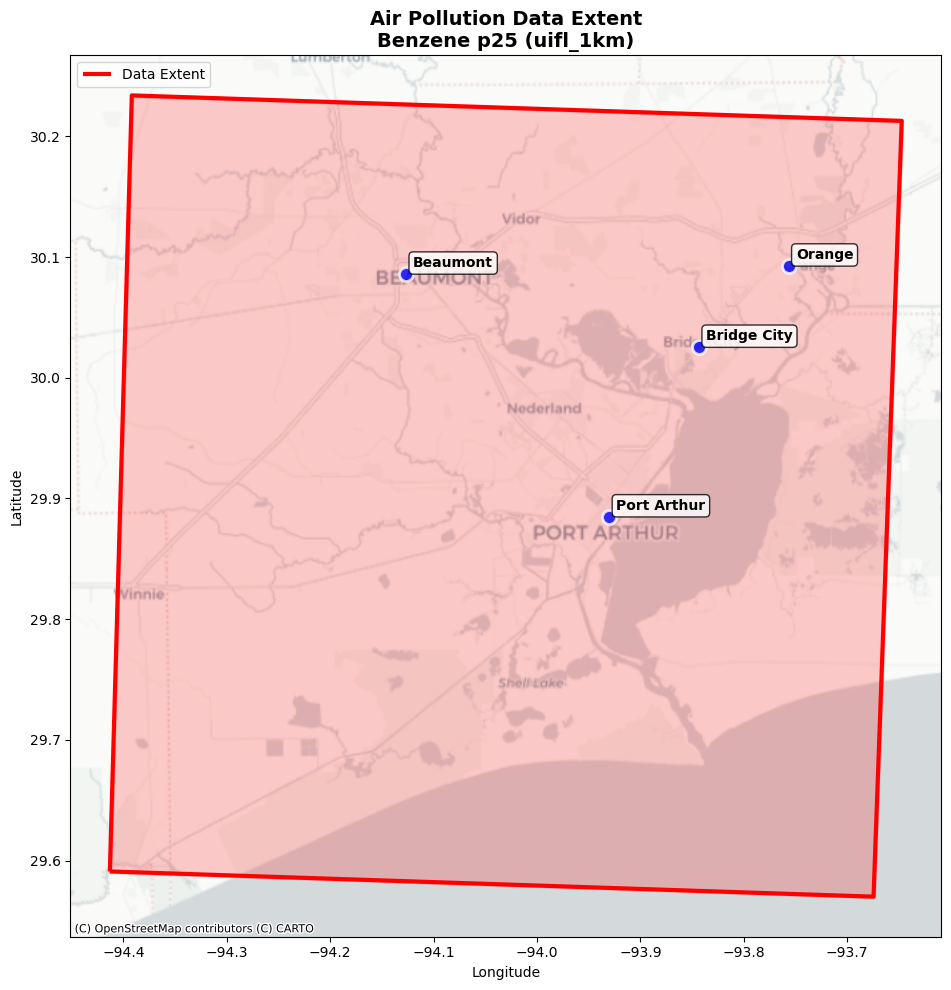

In [10]:
# Test the updated functions with WGS84 (standard lat/lon decimal degrees)
extent_gdf_wgs84 = plot_data_extent_on_basemap('uifl_1km', 'Benzene', 'p25')

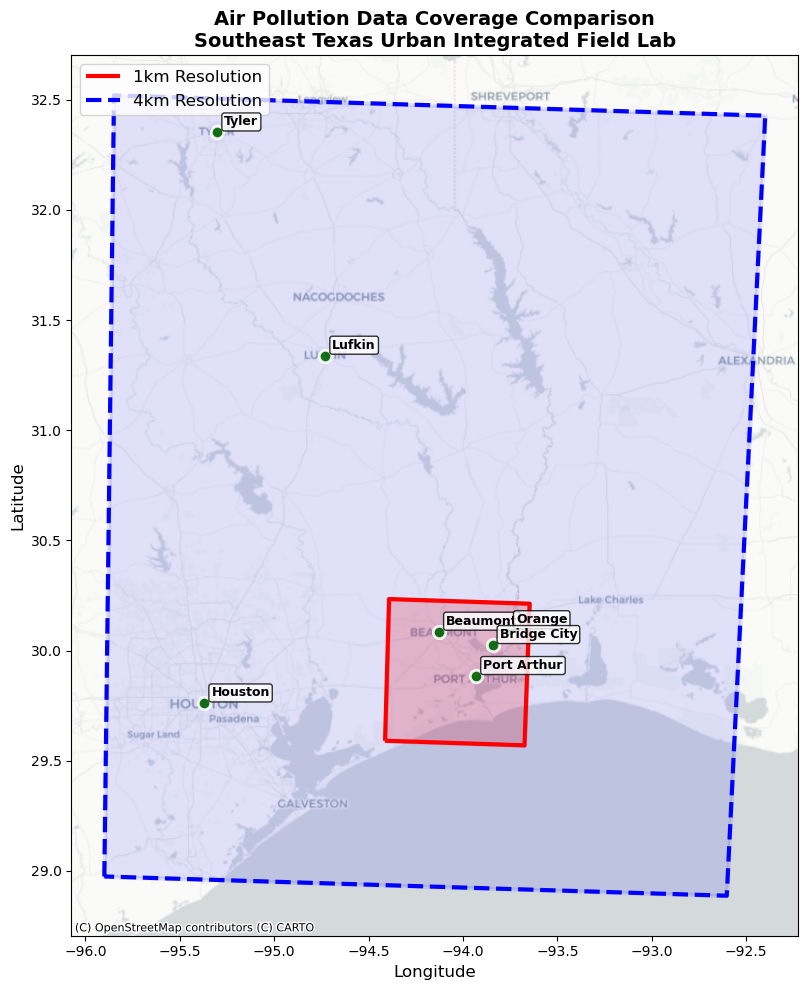

Data Coverage Comparison:
  1km Resolution Area: 5.18e+09 square units
  4km Resolution Area: 1.28e+11 square units
  Coverage Overlap: Yes


In [11]:
plot_multiple_extents_comparison()

# Convert GEOTiff into Gridded Vector with unique ID for each grid


In [ ]:
# Convert first 4km geotiff to vector grid with unique polygon for each cell
import numpy as np
from shapely.geometry import Polygon
import geopandas as gpd

def create_grid_polygons_from_raster(raster_data, resolution):
    """
    Convert raster cells to vector polygons with unique IDs, including resolution.

    Args:
        raster_data: Dictionary containing raster information.
        resolution: String representing the resolution (e.g., 'uifl_4km').

    Returns:
        GeoDataFrame with polygon for each grid cell.
    """
    # Get raster properties
    transform = raster_data['transform']
    data_array = raster_data['data'][0]  # Get first band
    height, width = data_array.shape
    crs = raster_data['crs']

    print(f"Creating vector grid from raster:")
    print(f"  Dimensions: {width} x {height} = {width * height:,} cells")
    print(f"  CRS: {crs}")
    print(f"  Cell size: {abs(transform[0]):.1f} x {abs(transform[4]):.1f} units")

    # Lists to store polygon data
    polygons = []
    grid_ids = []
    row_indices = []
    col_indices = []

    # Get cell dimensions
    cell_width = abs(transform[0])   # x-direction pixel size
    cell_height = abs(transform[4])  # y-direction pixel size

    # Get upper-left corner coordinates
    x_origin = transform[2]  # x-coordinate of upper-left corner
    y_origin = transform[5]  # y-coordinate of upper-left corner

    print("Creating polygons for each grid cell...")

    # Create polygon for each raster cell
    for row in range(height):
        for col in range(width):
            # Calculate cell center coordinates
            x_center = x_origin + (col + 0.5) * cell_width
            y_center = y_origin - (row + 0.5) * cell_height  # Note: negative because y decreases

            # Calculate cell corner coordinates
            x_left = x_center - cell_width / 2
            x_right = x_center + cell_width / 2
            y_top = y_center + cell_height / 2
            y_bottom = y_center - cell_height / 2

            # Create polygon (counter-clockwise)
            cell_polygon = Polygon([
                (x_left, y_bottom),   # bottom-left
                (x_right, y_bottom),  # bottom-right
                (x_right, y_top),     # top-right
                (x_left, y_top),      # top-left
                (x_left, y_bottom)    # close polygon
            ])

            # Create unique grid ID with resolution
            grid_id = f"air{resolution}_{row:04d}_{col:04d}"

            # Store data
            polygons.append(cell_polygon)
            grid_ids.append(grid_id)
            row_indices.append(row)
            col_indices.append(col)

    # Create GeoDataFrame
    grid_gdf = gpd.GeoDataFrame({
        'air_grid_id': grid_ids,
        'row_idx': row_indices,
        'col_idx': col_indices,
        'geometry': polygons
    }, crs=crs)

    print(f"Successfully created {len(grid_gdf):,} grid polygons")

    return grid_gdf

def add_raster_values_to_grid(grid_gdf, air_pollution_dict, input_resolution):
    """
    Add raster values from air_pollution_dict to the grid GeoDataFrame.

    Args:
        grid_gdf: GeoDataFrame containing grid polygons.
        air_pollution_dict: Dictionary containing raster data for various resolutions/species/statistics.

    Returns:
        Updated GeoDataFrame with raster values added as columns.
    """
    for resolution, species_data in air_pollution_dict.items():
        # Skip raster data that does not match the grid resolution
        if resolution != input_resolution:
            print(f"Skipping raster data for {resolution} as it does not match the grid resolution.")
            continue

        for species, stats_data in species_data.items():
            for statistic, raster_data in stats_data.items():
                # Extract raster values for the grid
                try:
                    data_array = raster_data['data'][0]  # Get first band
                    raster_values = np.array([data_array[row, col] for row, col in zip(grid_gdf['row_idx'], grid_gdf['col_idx'])])
                except IndexError as e:
                    print(f"Error accessing raster data for {resolution}, {species}, {statistic}: {e}")
                    continue

                # Add raster values as a new column
                column_name = f"{resolution}_{species}_{statistic}"
                if len(column_name) > 50:  # Truncate long column names
                    column_name = column_name[:47] + "..."
                grid_gdf[column_name] = raster_values

    print("Successfully added raster values to the grid.")
    return grid_gdf

# Get the first 4km geotiff
resolution_4km = 'uifl_4km'
first_species_4km = list(air_pollution_dict[resolution_4km].keys())[0]
first_statistic_4km = list(air_pollution_dict[resolution_4km][first_species_4km].keys())[0]

print(f"Converting to vector grid: {resolution_4km} -> {first_species_4km} -> {first_statistic_4km}")

# Get the raster data
raster_data_4km = air_pollution_dict[resolution_4km][first_species_4km][first_statistic_4km]

# Create vector grid with resolution
grid_4km_gdf = create_grid_polygons_from_raster(raster_data_4km, resolution_4km)

# Add raster values to the grid
grid_4km_gdf = add_raster_values_to_grid(grid_4km_gdf, air_pollution_dict)

# Get the first 4km geotiff
resolution_1km = 'uifl_1km'
first_species_1km = list(air_pollution_dict[resolution_1km].keys())[0]
first_statistic_1km = list(air_pollution_dict[resolution_1km][first_species_1km].keys())[0]

print(f"Converting to vector grid: {resolution_1km} -> {first_species_1km} -> {first_statistic_1km}")

# Get the raster data
raster_data_1km = air_pollution_dict[resolution_1km][first_species_1km][first_statistic_1km]
# Create vector grid with resolution
grid_1km_gdf = create_grid_polygons_from_raster(raster_data_1km, resolution_1km)

# Add raster values to the grid
grid_1km_gdf = add_raster_values_to_grid(grid_1km_gdf, air_pollution_dict)

Converting to vector grid: uifl_4km -> Benzene -> p100
Creating vector grid from raster:
  Dimensions: 81 x 99 = 8,019 cells
  CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["unknown",6370000,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",40],PARAMETER["central_meridian",-97],PARAMETER["standard_parallel_1",33],PARAMETER["standard_parallel_2",45],PARAMETER["false_easting",-108000],PARAMETER["false_northing",1224000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
  Cell size: 4000.0 x 4000.0 units
Creating polygons for each grid cell...
Successfully created 8,019 grid polygons
Skipping raster data for uifl_1km as it does not match the grid resolution.
Successfully added raster values to the grid.
Converting to vector grid: uifl_1km -> Benzene -> p75
Creating vector grid from raster:
  Dimensions: 72 x 72 = 5,184 cells
  C

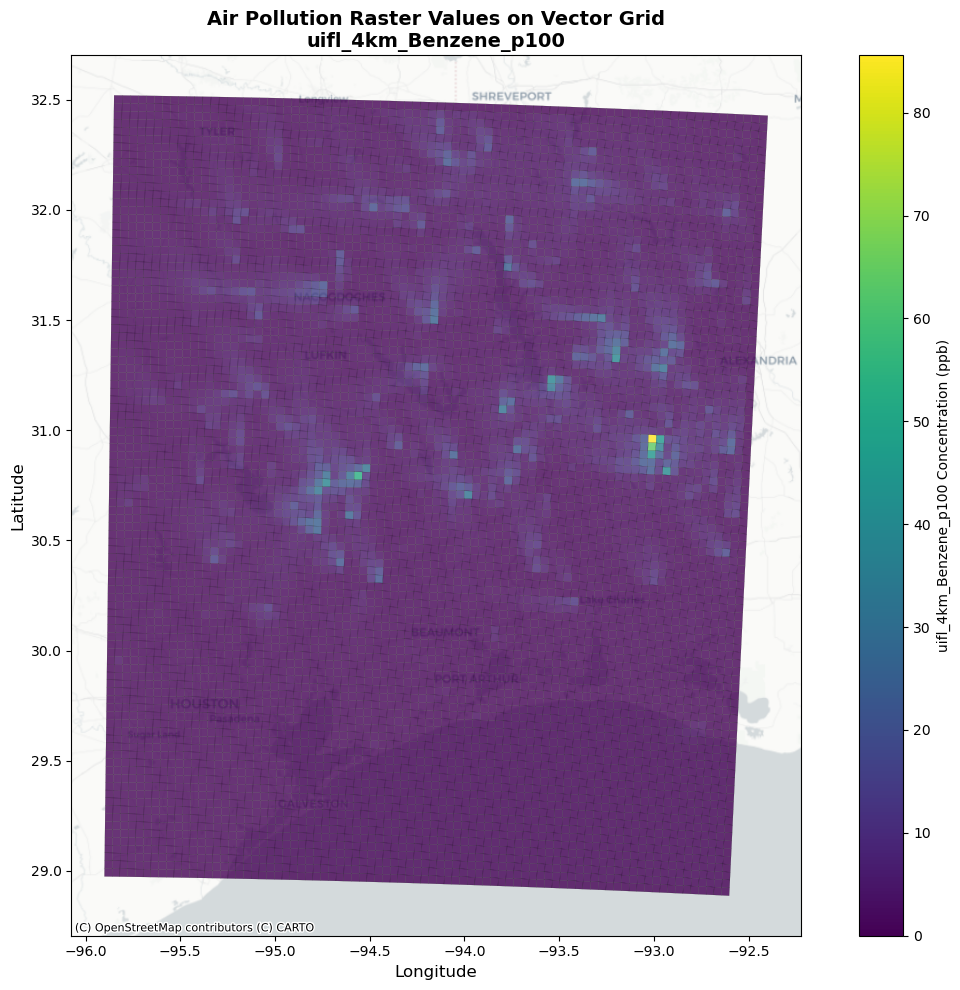

In [53]:
# plot uifl_4km_Benzene_p100 raster values
def plot_raster_values_on_grid(grid_gdf, column_name):
    """Plot raster values on the vector grid with CartoDB Positron basemap"""
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Convert to WGS84 for basemap compatibility if needed
    if grid_gdf.crs.to_string() != 'EPSG:4326':
        grid_wgs84 = grid_gdf.to_crs('EPSG:4326')
    else:
        grid_wgs84 = grid_gdf
    
    # Plot the grid with raster values
    grid_wgs84.plot(column=column_name, ax=ax, cmap='viridis', legend=True,
                    legend_kwds={'label': f"{column_name} Concentration (ppb)"},
                    edgecolor='black', linewidth=0.1, alpha=0.8)
    
    # Add CartoDB Positron basemap
    try:
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=grid_wgs84.crs.to_string())
    except Exception as e:
        print(f"Warning: Could not add basemap: {e}")
    
    # Add title and labels
    ax.set_title(f'Air Pollution Raster Values on Vector Grid\n{column_name}', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Define the column name for uifl_4km_Benzene_p100
column_name = 'uifl_4km_Benzene_p100'
# Plot the raster values on the grid
plot_raster_values_on_grid(grid_4km_gdf, column_name)

In [55]:
grid_1km_gdf.head()

air_grid_id  row_idx  col_idx  \
0  airuifl_1km_0000_0000        0        0   
1  airuifl_1km_0000_0001        0        1   
2  airuifl_1km_0000_0002        0        2   
3  airuifl_1km_0000_0003        0        3   
4  airuifl_1km_0000_0004        0        4   

                                            geometry  uifl_4km_Benzene_p100  \
0  POLYGON ((0 71000, 1000 71000, 1000 72000, 0 7...                    0.0   
1  POLYGON ((1000 71000, 2000 71000, 2000 72000, ...                    0.0   
2  POLYGON ((2000 71000, 3000 71000, 3000 72000, ...                    0.0   
3  POLYGON ((3000 71000, 4000 71000, 4000 72000, ...                    0.0   
4  POLYGON ((4000 71000, 5000 71000, 5000 72000, ...                    0.0   

   uifl_4km_Benzene_p95  uifl_4km_Benzene_mean  uifl_4km_Benzene_p90  \
0                   0.0                    0.0                   0.0   
1                   0.0                    0.0                   0.0   
2                   0.0                    0.0                   0.0   
3                   0.0                    0.0                   0.0   
4                   0.0                    0.0                   0.0   

   uifl_4km_Benzene_p75  uifl_4km_Benzene_p50  ...  uifl_4km_Ethylbenzene_p25  \
0                   0.0                   0.0  ...                        0.0   
1                   0.0                   0.0  ...                        0.0   
2                   0.0                   0.0  ...                        0.0   
3                   0.0                   0.0  ...                        0.0   
4                   0.0                   0.0  ...                        0.0   

   uifl_4km_Xylenes_p100  uifl_4km_Xylenes_p50  uifl_4km_Xylenes_p99  \
0                    0.0                   0.0                   0.0   
1                    0.0                   0.0                   0.0   
2                    0.0                   0.0                   0.0   
3                    0.0                   0.0                   0.0   
4                    0.0                   0.0                   0.0   

   uifl_4km_Xylenes_p98  uifl_4km_Xylenes_mean  uifl_4km_Xylenes_p75  \
0                   0.0                    0.0                   0.0   
1                   0.0                    0.0                   0.0   
2                   0.0                    0.0                   0.0   
3                   0.0                    0.0                   0.0   
4                   0.0                    0.0                   0.0   

   uifl_4km_Xylenes_p25  uifl_4km_Xylenes_p90  uifl_4km_Xylenes_p95  
0                   0.0                   0.0                   0.0  
1                   0.0                   0.0                   0.0  
2                   0.0                   0.0                   0.0  
3                   0.0                   0.0                   0.0  
4                   0.0                   0.0                   0.0  

[5 rows x 85 columns]

KeyError: 'uifl_1km_Benzene_p100'

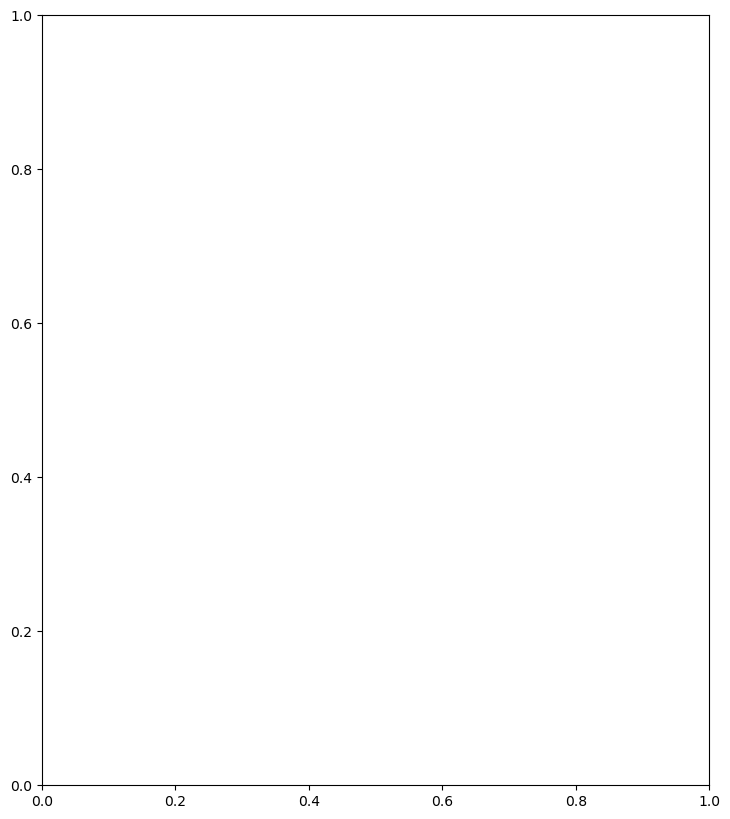

In [54]:
# Define the column name for uifl_1km_Benzene_p100
column_name = 'uifl_1km_Benzene_p100'
# Plot the raster values on the grid
plot_raster_values_on_grid(grid_1km_gdf, column_name)

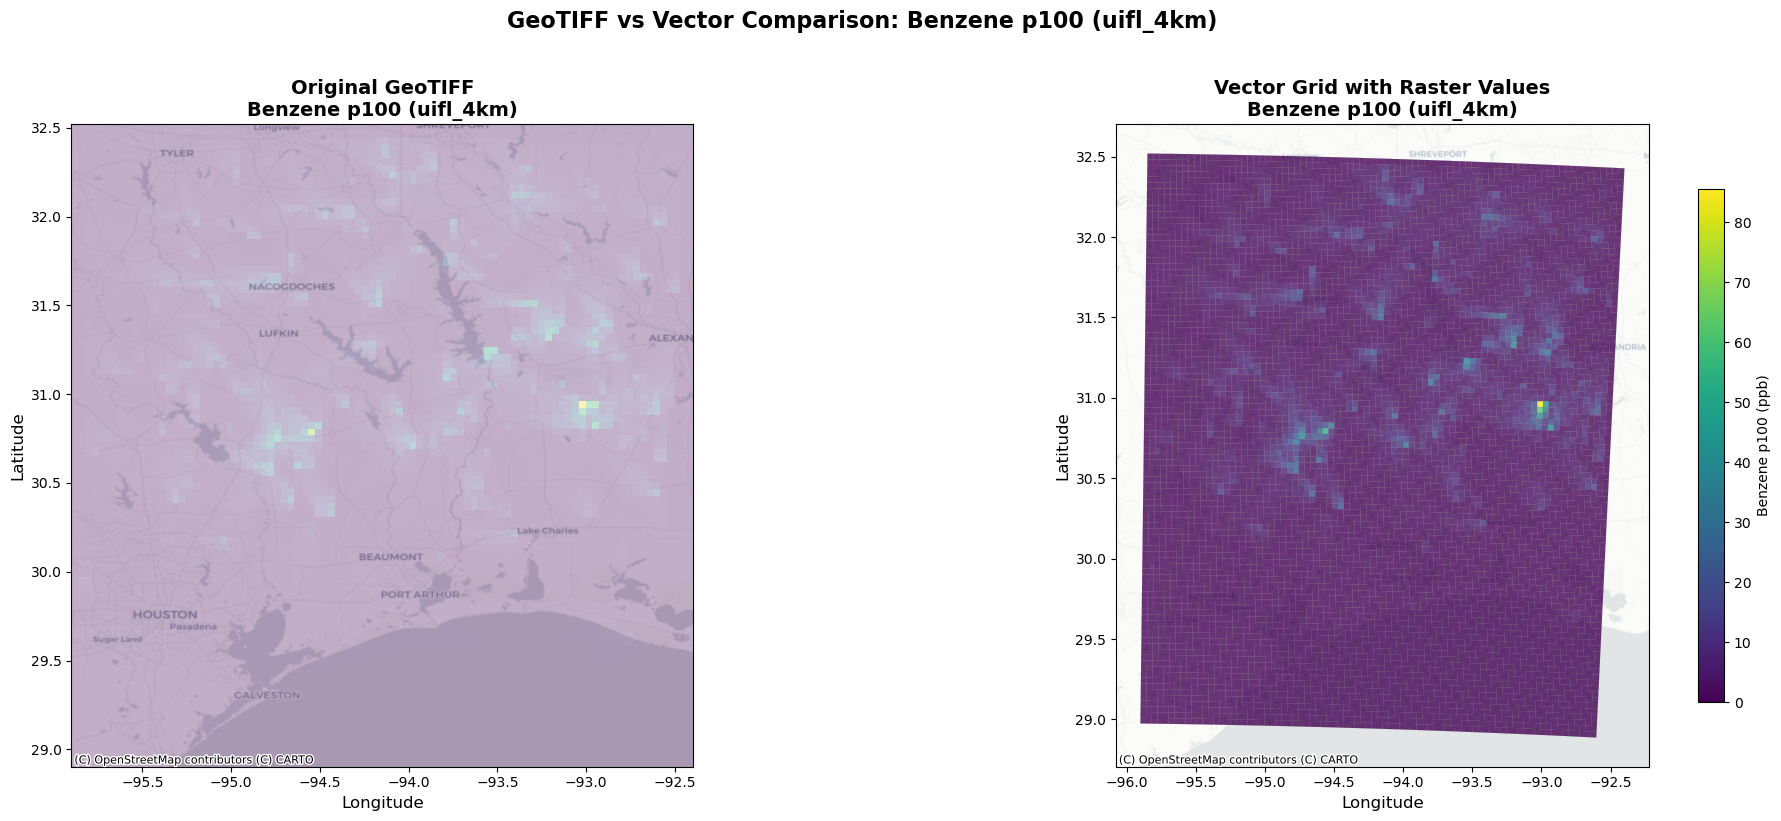


Comparison Statistics:
Original GeoTIFF:
  Data range: 0.000 to 85.573
  Mean value: 2.013
  Shape: (99, 81)

Vector Grid:
  Data range: 0.000 to 85.573
  Mean value: 2.013
  Number of cells: 8019

Data Validation:
  Maximum difference between raster and vector: 0.000000
  ✓ Values match perfectly between raster and vector!


In [51]:
# Compare original GeoTIFF with vector file side by side using p100 benzene data
def compare_geotiff_vs_vector(resolution='uifl_4km', species='Benzene', statistic='p100'):
    """
    Create side-by-side comparison of original GeoTIFF and vector file with raster values
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Get the original raster data
    raster_data = air_pollution_dict[resolution][species][statistic]
    data_array = raster_data['data'][0]  # First band
    transform = raster_data['transform']

    # Create column name for vector data
    column_name = f"{resolution}_{species}_{statistic}"

    # Plot 1: Original GeoTIFF
    ax1 = axes[0]
    from rasterio.plot import show
    from rasterio.warp import calculate_default_transform, reproject, Resampling

    # Transform raster to WGS84 if needed
    if str(raster_data['crs']) != 'EPSG:4326':
        dst_crs = 'EPSG:4326'
        transform, width, height = calculate_default_transform(
            raster_data['crs'], dst_crs, raster_data['width'], raster_data['height'], *raster_data['bounds']
        )
        data_array_wgs84 = np.empty((height, width), dtype=data_array.dtype)

        reproject(
            source=data_array,
            destination=data_array_wgs84,
            src_transform=raster_data['transform'],
            src_crs=raster_data['crs'],
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest
        )

        img = show(data_array_wgs84, transform=transform, ax=ax1, cmap='viridis')
    else:
        img = show(data_array, transform=transform, ax=ax1, cmap='viridis')

    # Add CartoDB Positron basemap to raster plot
    try:
        ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron, crs='EPSG:4326', alpha=0.7)
    except Exception as e:
        print(f"Could not add basemap to raster plot: {e}")

    ax1.set_title(f'Original GeoTIFF\n{species} {statistic} ({resolution})', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Longitude', fontsize=12)
    ax1.set_ylabel('Latitude', fontsize=12)

    # Plot 2: Vector file with raster values
    ax2 = axes[1]

    # Convert grid to WGS84 for basemap compatibility if needed
    if grid_4km_gdf.crs.to_string() != 'EPSG:4326':
        grid_wgs84 = grid_4km_gdf.to_crs('EPSG:4326')
    else:
        grid_wgs84 = grid_4km_gdf

    # Plot the grid with raster values
    grid_wgs84.plot(column=column_name, ax=ax2, cmap='viridis', legend=True,
                    legend_kwds={'label': f'{species} {statistic} (ppb)', 'shrink': 0.8},
                    edgecolor='black', linewidth=0.05, alpha=0.8)

    # Add CartoDB Positron basemap to vector plot
    try:
        ctx.add_basemap(ax2, source=ctx.providers.CartoDB.Positron, crs=grid_wgs84.crs.to_string(), alpha=0.7)
    except Exception as e:
        print(f"Warning: Could not add basemap to vector plot: {e}")

    ax2.set_title(f'Vector Grid with Raster Values\n{species} {statistic} ({resolution})', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Longitude', fontsize=12)
    ax2.set_ylabel('Latitude', fontsize=12)

    # Add overall title
    fig.suptitle(f'GeoTIFF vs Vector Comparison: {species} {statistic} ({resolution})', 
                 fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.show()

    # Print comparison statistics
    print(f"\nComparison Statistics:")
    print(f"Original GeoTIFF:")
    print(f"  Data range: {data_array.min():.3f} to {data_array.max():.3f}")
    print(f"  Mean value: {data_array.mean():.3f}")
    print(f"  Shape: {data_array.shape}")

    print(f"\nVector Grid:")
    vector_values = grid_4km_gdf[column_name]
    print(f"  Data range: {vector_values.min():.3f} to {vector_values.max():.3f}")
    print(f"  Mean value: {vector_values.mean():.3f}")
    print(f"  Number of cells: {len(vector_values)}")

    # Check if values match exactly
    raster_flat = data_array.flatten()  # Use the original data for comparison
    vector_flat = vector_values.values
    if len(raster_flat) == len(vector_flat):
        differences = abs(raster_flat - vector_flat)
        max_diff = differences.max()
        print(f"\nData Validation:")
        print(f"  Maximum difference between raster and vector: {max_diff:.6f}")
        if max_diff < 1e-10:
            print("  ✓ Values match perfectly between raster and vector!")
        else:
            print(f"  ⚠ Some differences found (max: {max_diff:.6f})")
    else:
        print(f"\nData shapes differ: Raster {raster_flat.shape} vs Vector {vector_flat.shape}")

# Create the comparison using p100 benzene data
compare_geotiff_vs_vector('uifl_4km', 'Benzene', 'p100')

In [19]:
# Also create vector grid for 1km resolution for comparison
resolution_1km = 'uifl_1km'
first_species_1km = list(air_pollution_dict[resolution_1km].keys())[0]
first_statistic_1km = list(air_pollution_dict[resolution_1km][first_species_1km].keys())[0]

print(f"Creating 1km vector grid: {resolution_1km} -> {first_species_1km} -> {first_statistic_1km}")

# Get the raster data
raster_data_1km = air_pollution_dict[resolution_1km][first_species_1km][first_statistic_1km]

# Create vector grid (this will take longer due to higher resolution)
print("Note: 1km grid creation may take several minutes due to higher resolution...")
grid_1km_gdf = create_grid_polygons_from_raster(raster_data_1km, resolution_1km)

# Display basic information
print(f"\n1km Vector Grid Summary:")
print(f"  Total polygons: {len(grid_1km_gdf):,}")
print(f"  CRS: {grid_1km_gdf.crs}")
print(f"  Raster value range: {grid_1km_gdf['raster_value'].min():.3f} to {grid_1km_gdf['raster_value'].max():.3f}")
print(f"  Valid (non-NaN) values: {grid_1km_gdf['raster_value'].notna().sum():,}")

# Compare grid sizes
print(f"\nResolution Comparison:")
print(f"  4km grid: {len(grid_4km_gdf):,} polygons")
print(f"  1km grid: {len(grid_1km_gdf):,} polygons") 
print(f"  Ratio: {len(grid_1km_gdf) / len(grid_4km_gdf):.1f}x more cells in 1km grid")

# Show memory usage
import sys
grid_4km_memory = sys.getsizeof(grid_4km_gdf)
grid_1km_memory = sys.getsizeof(grid_1km_gdf)
print(f"\nApproximate Memory Usage:")
print(f"  4km grid: {grid_4km_memory / 1_000_000:.1f} MB")
print(f"  1km grid: {grid_1km_memory / 1_000_000:.1f} MB")

Creating 1km vector grid: uifl_1km -> Benzene -> p75
Note: 1km grid creation may take several minutes due to higher resolution...
Creating vector grid from raster:
  Dimensions: 72 x 72 = 5,184 cells
  CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["unknown",6370000,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",40],PARAMETER["central_meridian",-97],PARAMETER["standard_parallel_1",33],PARAMETER["standard_parallel_2",45],PARAMETER["false_easting",-252000],PARAMETER["false_northing",1152000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
  Cell size: 1000.0 x 1000.0 units
Creating polygons for each grid cell...
Successfully created 5,184 grid polygons

1km Vector Grid Summary:
  Total polygons: 5,184
  CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["unknown",6370000,0]],PRIMEM["Greenwich",0],UNIT["degree",

In [23]:
# Save vector grids to files for future use
import os

# Create output directory
output_dir = f"{programname}"

# Save 4km grid
grid_4km_filename = f"{programname}_grid_4km_{first_species_4km}_{first_statistic_4km}.gpkg"
grid_4km_filepath = os.path.join(output_dir, grid_4km_filename)

print(f"Saving 4km grid to: {grid_4km_filepath}")
grid_4km_gdf.to_file(grid_4km_filepath, driver='GPKG')
print(f"  ✓ Saved {len(grid_4km_gdf):,} polygons")

# Save 1km grid (if created)
if 'grid_1km_gdf' in locals():
    grid_1km_filename = f"{programname}_grid_1km_{first_species_1km}_{first_statistic_1km}.gpkg"
    grid_1km_filepath = os.path.join(output_dir, grid_1km_filename)
    
    print(f"Saving 1km grid to: {grid_1km_filepath}")
    grid_1km_gdf.to_file(grid_1km_filepath, driver='GPKG')
    print(f"  ✓ Saved {len(grid_1km_gdf):,} polygons")

# Also save as CSV with just the grid metadata (without geometry for faster loading)
print("\nCreating CSV versions (without geometry)...")

# 4km CSV
grid_4km_csv = grid_4km_gdf.drop(columns=['geometry']).copy()
grid_4km_csv_filepath = os.path.join(output_dir, grid_4km_filename.replace('.gpkg', '.csv'))
grid_4km_csv.to_csv(grid_4km_csv_filepath, index=False)
print(f"  ✓ Saved 4km grid CSV: {grid_4km_csv_filepath}")

# 1km CSV (if created)
if 'grid_1km_gdf' in locals():
    grid_1km_csv = grid_1km_gdf.drop(columns=['geometry']).copy()
    grid_1km_csv_filepath = os.path.join(output_dir, grid_1km_filename.replace('.gpkg', '.csv'))
    grid_1km_csv.to_csv(grid_1km_csv_filepath, index=False)
    print(f"  ✓ Saved 1km grid CSV: {grid_1km_csv_filepath}")

print(f"\nOutput files saved in: {output_dir}")
print("Files include:")
print("  - .gpkg: Full vector data with polygon geometries")
print("  - .csv: Grid metadata only (grid_id, row_idx, col_idx, raster_value)")

# Display final summary
print(f"\n" + "="*60)
print("VECTOR GRID CREATION COMPLETE")
print("="*60)
print(f"Successfully converted raster to vector grids:")
print(f"  4km resolution: {len(grid_4km_gdf):,} polygons")
if 'grid_1km_gdf' in locals():
    print(f"  1km resolution: {len(grid_1km_gdf):,} polygons")
print(f"Each grid cell has:")
print(f"  - Unique grid_id (format: grid_RRRR_CCCC)")
print(f"  - Row and column indices")
print(f"  - Original raster value")
print(f"  - Polygon geometry")
print(f"\nThese grids can be used for fast spatial joins with point data!")

Saving 4km grid to: ip1_2av1_covertairtocsv\ip1_2av1_covertairtocsv_grid_4km_Benzene_p100.gpkg
  ✓ Saved 8,019 polygons
Saving 1km grid to: ip1_2av1_covertairtocsv\ip1_2av1_covertairtocsv_grid_1km_Benzene_p75.gpkg
  ✓ Saved 5,184 polygons

Creating CSV versions (without geometry)...
  ✓ Saved 4km grid CSV: ip1_2av1_covertairtocsv\ip1_2av1_covertairtocsv_grid_4km_Benzene_p100.csv
  ✓ Saved 1km grid CSV: ip1_2av1_covertairtocsv\ip1_2av1_covertairtocsv_grid_1km_Benzene_p75.csv

Output files saved in: ip1_2av1_covertairtocsv
Files include:
  - .gpkg: Full vector data with polygon geometries
  - .csv: Grid metadata only (grid_id, row_idx, col_idx, raster_value)

VECTOR GRID CREATION COMPLETE
Successfully converted raster to vector grids:
  4km resolution: 8,019 polygons
  1km resolution: 5,184 polygons
Each grid cell has:
  - Unique grid_id (format: grid_RRRR_CCCC)
  - Row and column indices
  - Original raster value
  - Polygon geometry

These grids can be used for fast spatial joins with 

Plotting full 1km grid with 5,184 grid cells

✓ Saved comparison map: ip1_2av1_covertairtocsv\ip1_2av1_covertairtocsv_vector_grids_comparison.png


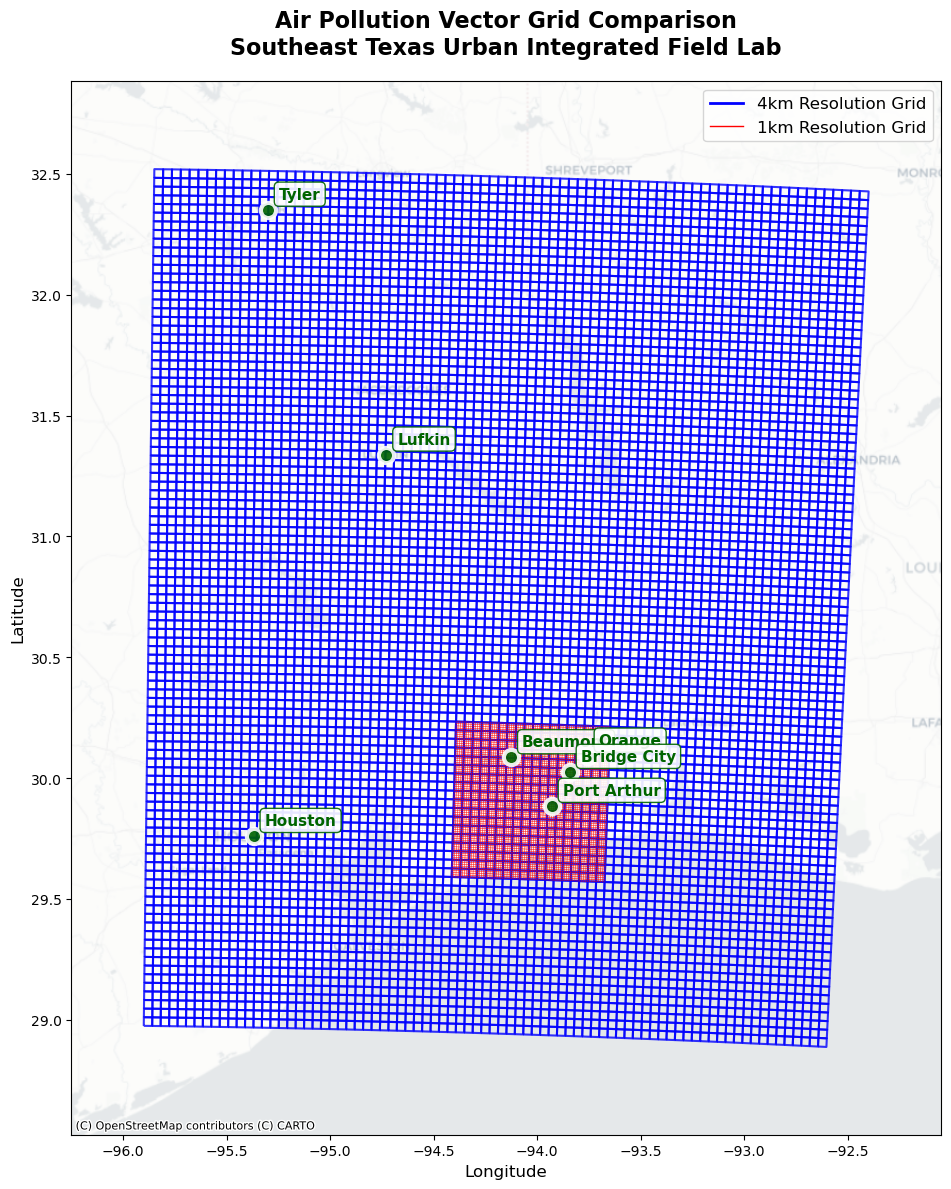


Vector Grid Comparison Summary:
  4km Grid: 8,019 total polygons
  1km Grid: 5,184 total polygons
  Resolution Ratio: 0.6x more cells in 1km
  Average cell area - 4km: 21.5 km², 1km: 1.3 km²


In [31]:
# Create comparison map showing both 4km and 1km vector grids
def plot_vector_grids_comparison():
    """Compare the vector polygon grids of 1km and 4km resolution data"""

    fig, ax = plt.subplots(figsize=(16, 12))

    # Convert both grids to WGS84 for plotting
    grid_4km_wgs84 = grid_4km_gdf.to_crs('EPSG:4326')

    # Check if 1km grid exists and convert to WGS84
    try:
        if 'grid_1km_gdf' in globals() and len(grid_1km_gdf) > 0:
            grid_1km_wgs84 = grid_1km_gdf.to_crs('EPSG:4326')
            print(f"Plotting full 1km grid with {len(grid_1km_wgs84):,} grid cells")
        else:
            grid_1km_wgs84 = None
            print("1km grid not available - plotting 4km grid only")
    except NameError:
        grid_1km_wgs84 = None
        print("1km grid not created yet - plotting 4km grid only")

    # Set axis limits to focus on the data extent BEFORE adding basemap
    bounds_4km = grid_4km_wgs84.total_bounds
    margin = 0.1  # Add 10% margin
    x_margin = (bounds_4km[2] - bounds_4km[0]) * margin
    y_margin = (bounds_4km[3] - bounds_4km[1]) * margin

    ax.set_xlim(bounds_4km[0] - x_margin, bounds_4km[2] + x_margin)
    ax.set_ylim(bounds_4km[1] - y_margin, bounds_4km[3] + y_margin)

    # Add base map first with proper transparency
    try:
        ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron, alpha=0.6)
        basemap_source = "CartoDB Positron"
    except Exception as e:
        print(f"Warning: Could not add base map: {e}")

    # Plot 4km grid boundaries (no fill for clarity, reduced alpha to show basemap)
    grid_4km_wgs84.boundary.plot(ax=ax, color='blue', linewidth=1.5, 
                                 label='4km Resolution Grid', alpha=0.8)

    # Plot 1km grid boundaries if available (plot full grid without sampling)
    if grid_1km_wgs84 is not None:
        grid_1km_wgs84.boundary.plot(ax=ax, color='red', linewidth=0.3, 
                                     label='1km Resolution Grid', alpha=0.7)

    # Add Texas cities for geographic context
    cities_data = []
    for city_name, coords in texas_cities.items():
        cities_data.append({
            'city': city_name,
            'geometry': sg.Point(coords['lon'], coords['lat'])
        })

    cities_gdf = gpd.GeoDataFrame(cities_data, crs='EPSG:4326')

    # Plot cities with larger markers
    cities_gdf.plot(ax=ax, color='darkgreen', markersize=120, alpha=0.9, 
                    edgecolor='white', linewidth=3, zorder=15)

    # Add city labels with better styling
    for idx, row in cities_gdf.iterrows():
        ax.annotate(row['city'], 
                    (row.geometry.x, row.geometry.y),
                    xytext=(8, 8), textcoords='offset points',
                    fontsize=11, fontweight='bold', color='darkgreen',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                              alpha=0.9, edgecolor='darkgreen'),
                    zorder=16)

    # Set plot properties
    ax.set_title('Air Pollution Vector Grid Comparison\nSoutheast Texas Urban Integrated Field Lab', 
                 fontsize=16, fontweight='bold', pad=20)

    # Create custom legend
    legend_elements = [
        plt.Line2D([0], [0], color='blue', linewidth=2, label='4km Resolution Grid'),
    ]

    if grid_1km_wgs84 is not None:
        legend_elements.append(
            plt.Line2D([0], [0], color='red', linewidth=1, label='1km Resolution Grid')
        )

    ax.legend(handles=legend_elements, loc='upper right', fontsize=12)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)

    plt.tight_layout()

    # Save the map to output folder
    map_filename = f"{programname}_vector_grids_comparison.png"
    map_filepath = os.path.join(output_dir, map_filename)
    plt.savefig(map_filepath, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"\n✓ Saved comparison map: {map_filepath}")

    plt.show()

    # Print comparison information
    print(f"\nVector Grid Comparison Summary:")
    print(f"  4km Grid: {len(grid_4km_gdf):,} total polygons")
    try:
        if 'grid_1km_gdf' in globals() and len(grid_1km_gdf) > 0:
            print(f"  1km Grid: {len(grid_1km_gdf):,} total polygons")
            print(f"  Resolution Ratio: {len(grid_1km_gdf) / len(grid_4km_gdf):.1f}x more cells in 1km")

            # Calculate average grid cell areas
            area_4km = grid_4km_gdf.to_crs('EPSG:3857').area.mean() / 1_000_000  # Convert to km²
            area_1km = grid_1km_gdf.to_crs('EPSG:3857').area.mean() / 1_000_000
            print(f"  Average cell area - 4km: {area_4km:.1f} km², 1km: {area_1km:.1f} km²")
        else:
            print("  1km Grid: Not created yet")
    except NameError:
        print("  1km Grid: Variable not defined")

plot_vector_grids_comparison()

Zooming to 1km grid extent with 5,184 grid cells
Using CartoDB basemap

✓ Saved zoomed comparison map: ip1_2av1_covertairtocsv\ip1_2av1_covertairtocsv_vector_grids_comparison_zoomed.png


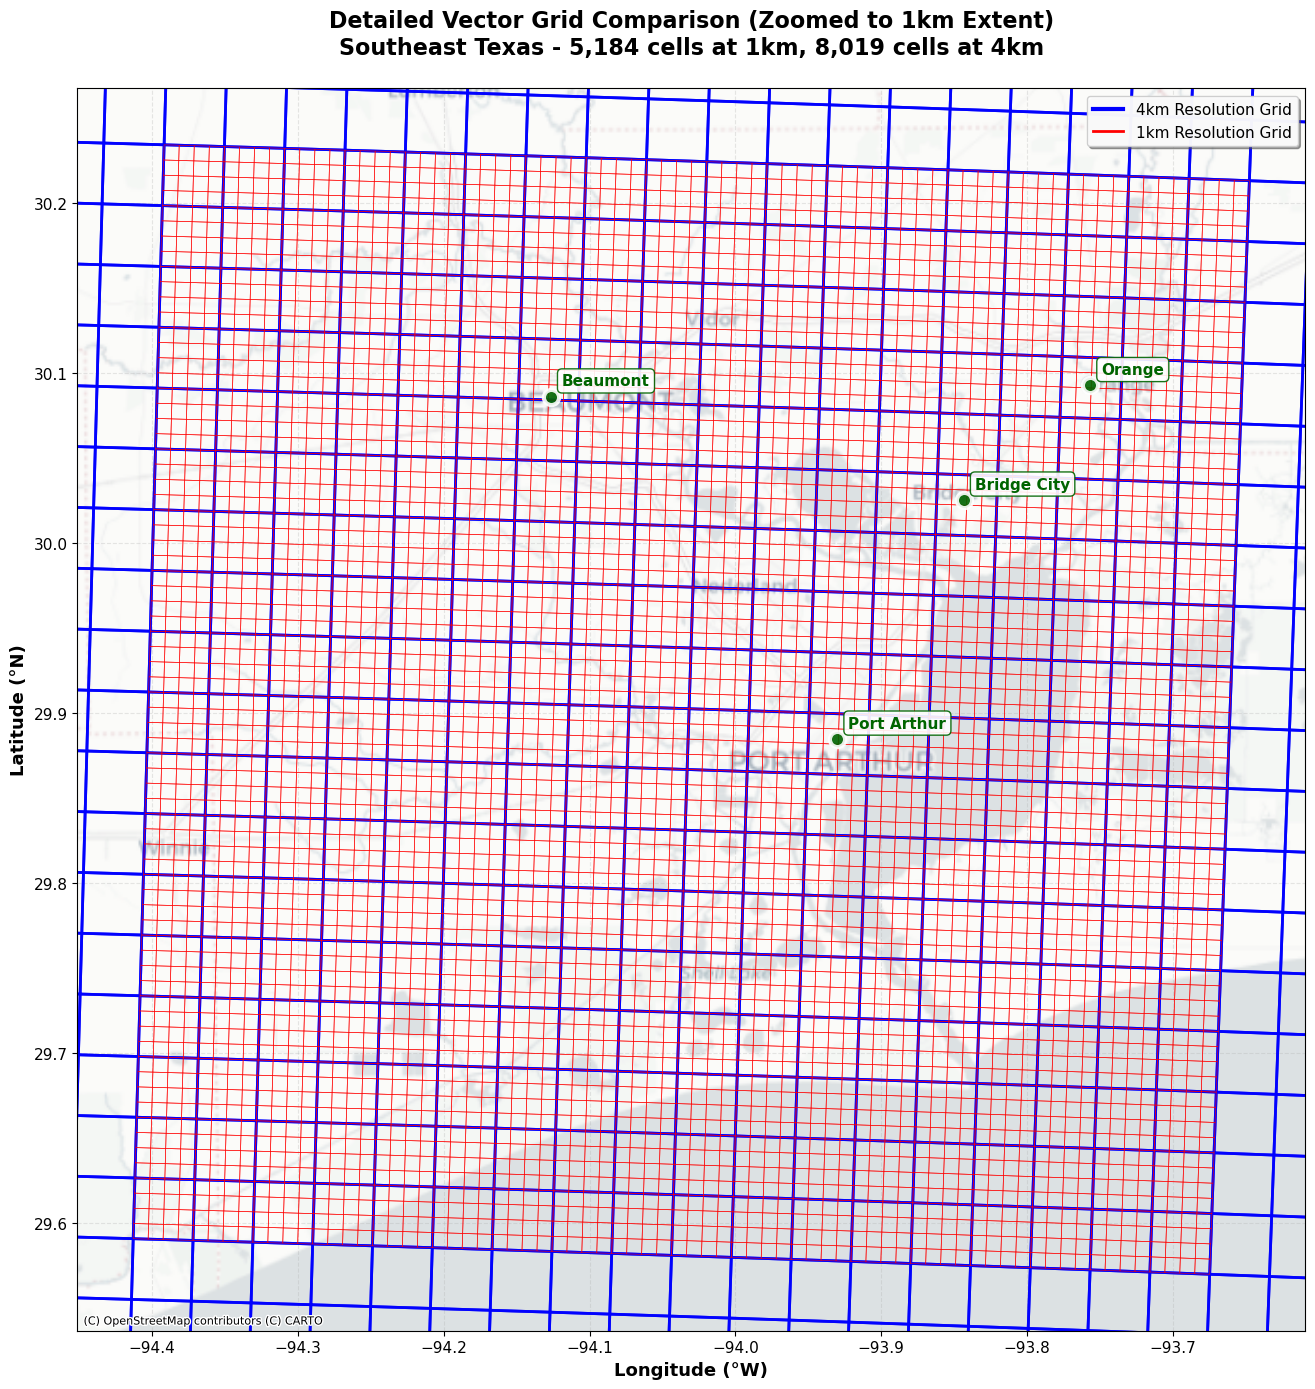


ZOOMED VECTOR GRID COMPARISON
Zoom extent: -94.4131°W to -93.6473°W, 29.5701°N to 30.2340°N
Map area: ~85 km × 74 km

Grid Details:
  4km Grid: 8,019 total polygons
  1km Grid: 5,184 total polygons
  Resolution Factor: 0.6x more detail in 1km
  Grid Density: 4km = 1.28 cells/km², 1km = 0.83 cells/km²

Visualization:
  Basemap: CartoDB Positron
  Cities in view: 7
  Zoom level: Detailed view of data extent


In [35]:
# Create zoomed-in comparison map focusing on 1km grid extent
def plot_vector_grids_comparison_zoomed():
    """Compare vector grids zoomed to 1km resolution extent with basemap"""

    fig, ax = plt.subplots(figsize=(18, 14))

    # Convert both grids to WGS84 for plotting
    grid_4km_wgs84 = grid_4km_gdf.to_crs('EPSG:4326')

    # Check if 1km grid exists and convert to WGS84
    grid_1km_wgs84 = None
    zoom_bounds = None

    try:
        if 'grid_1km_gdf' in globals() and len(grid_1km_gdf) > 0:
            grid_1km_wgs84 = grid_1km_gdf.to_crs('EPSG:4326')
            zoom_bounds = grid_1km_wgs84.total_bounds
            print(f"Zooming to 1km grid extent with {len(grid_1km_wgs84):,} grid cells")
        else:
            # Fallback to 4km bounds if 1km not available
            zoom_bounds = grid_4km_wgs84.total_bounds
            print("1km grid not available - using 4km grid extent")
    except NameError:
        zoom_bounds = grid_4km_wgs84.total_bounds
        print("1km grid not created yet - using 4km grid extent")

    # Set the axis limits first for proper basemap loading
    margin = 0.05  # 5% margin around the data
    x_margin = (zoom_bounds[2] - zoom_bounds[0]) * margin
    y_margin = (zoom_bounds[3] - zoom_bounds[1]) * margin

    ax.set_xlim(zoom_bounds[0] - x_margin, zoom_bounds[2] + x_margin)
    ax.set_ylim(zoom_bounds[1] - y_margin, zoom_bounds[3] + y_margin)

    # Add high-resolution base map
    try:
        ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron, alpha=0.8)
        basemap_source = "CartoDB Positron"
        print("Using CartoDB basemap")
    except:
        try:
            ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.Esri.WorldImagery, alpha=0.8)
            basemap_source = "Esri World Imagery"
            print("Using satellite imagery basemap")
        except:
            try:
                ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.8)
                basemap_source = "OpenStreetMap"
                print("Using OpenStreetMap basemap")
            except Exception as e:
                print(f"Warning: Could not add base map: {e}")
                basemap_source = "None"

    # Plot 4km grid boundaries (thicker lines for visibility at zoom level)
    grid_4km_wgs84.boundary.plot(ax=ax, color='blue', linewidth=2.0, 
                                 label='4km Resolution Grid', alpha=0.9)

    # Plot 1km grid boundaries if available (finer lines but still visible)
    if grid_1km_wgs84 is not None:
        grid_1km_wgs84.boundary.plot(ax=ax, color='red', linewidth=0.5, 
                                    label='1km Resolution Grid', alpha=0.8)

    # Add Texas cities for geographic context
    cities_data = []
    for city_name, coords in texas_cities.items():
        cities_data.append({
            'city': city_name,
            'geometry': sg.Point(coords['lon'], coords['lat'])
        })

    cities_gdf = gpd.GeoDataFrame(cities_data, crs='EPSG:4326')

    # Plot cities with larger markers
    cities_gdf.plot(ax=ax, color='darkgreen', markersize=120, alpha=0.9, 
                    edgecolor='white', linewidth=3, zorder=15)

    # Add city labels with better styling
    for idx, row in cities_gdf.iterrows():
        ax.annotate(row['city'], 
                    (row.geometry.x, row.geometry.y),
                    xytext=(8, 8), textcoords='offset points',
                    fontsize=11, fontweight='bold', color='darkgreen',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                              alpha=0.9, edgecolor='darkgreen'),
                    zorder=16)

    # Set enhanced plot properties
    if grid_1km_wgs84 is not None:
        title_text = f'Detailed Vector Grid Comparison (Zoomed to 1km Extent)\nSoutheast Texas - {len(grid_1km_gdf):,} cells at 1km, {len(grid_4km_gdf):,} cells at 4km'
    else:
        title_text = 'Vector Grid Comparison (4km Resolution)\nSoutheast Texas Urban Integrated Field Lab'

    ax.set_title(title_text, fontsize=16, fontweight='bold', pad=25)

    # Create enhanced legend
    legend_elements = [
        plt.Line2D([0], [0], color='blue', linewidth=3, label='4km Resolution Grid'),
    ]

    if grid_1km_wgs84 is not None:
        legend_elements.append(
            plt.Line2D([0], [0], color='red', linewidth=2, label='1km Resolution Grid')
        )

    ax.legend(handles=legend_elements, loc='upper right', fontsize=11, 
              framealpha=0.95, fancybox=True, shadow=True)

    # Set enhanced axis labels
    ax.set_xlabel('Longitude (°W)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Latitude (°N)', fontsize=13, fontweight='bold')

    # Add grid for reference
    ax.grid(True, alpha=0.3, linestyle='--')

    # Enhance tick labels
    ax.tick_params(axis='both', which='major', labelsize=11)

    plt.tight_layout()

    # Save the zoomed map to output folder
    zoom_map_filename = f"{programname}_vector_grids_comparison_zoomed.png"
    zoom_map_filepath = os.path.join(output_dir, zoom_map_filename)
    plt.savefig(zoom_map_filepath, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"\n✓ Saved zoomed comparison map: {zoom_map_filepath}")

    plt.show()

    # Print enhanced comparison information
    print(f"\n" + "="*70)
    print("ZOOMED VECTOR GRID COMPARISON")
    print("="*70)
    print(f"Zoom extent: {zoom_bounds[0]:.4f}°W to {zoom_bounds[2]:.4f}°W, {zoom_bounds[1]:.4f}°N to {zoom_bounds[3]:.4f}°N")
    print(f"Map area: ~{(zoom_bounds[2]-zoom_bounds[0])*111:.0f} km × {(zoom_bounds[3]-zoom_bounds[1])*111:.0f} km")

    print(f"\nGrid Details:")
    print(f"  4km Grid: {len(grid_4km_gdf):,} total polygons")

    try:
        if 'grid_1km_gdf' in globals() and len(grid_1km_gdf) > 0:
            print(f"  1km Grid: {len(grid_1km_gdf):,} total polygons")
            print(f"  Resolution Factor: {len(grid_1km_gdf) / len(grid_4km_gdf):.1f}x more detail in 1km")

            # Calculate grid density in this view
            area_km2 = (zoom_bounds[2]-zoom_bounds[0]) * (zoom_bounds[3]-zoom_bounds[1]) * 111 * 111
            density_4km = len(grid_4km_gdf) / area_km2
            density_1km = len(grid_1km_gdf) / area_km2
            print(f"  Grid Density: 4km = {density_4km:.2f} cells/km², 1km = {density_1km:.2f} cells/km²")
        else:
            print("  1km Grid: Not available")
    except NameError:
        print("  1km Grid: Not created")